<a href="https://colab.research.google.com/github/Ikeda33/codespaces-railstutorial/blob/main/cnn_50epoch_flower_D_c_G_c_FID_KID_devide_1_color_relativistic1_hinge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#パッケージのダウンロード


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import argparse

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

In [5]:
import torchvision.transforms as transforms

In [6]:
import torchvision.datasets as dset

In [7]:
import torchvision.utils as vutils

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm

In [9]:
import glob

In [10]:
from torch.utils.data import Dataset
from PIL import Image

In [11]:
from torch.utils.data import DataLoader
import torchvision

In [12]:
!pip install torchmetrics
!pip install torchmetrics[image]

!pip install torch-fidelity

from torchmetrics.image.inception import InceptionScore


import torchmetrics
import torch_fidelity

import torch
_ = torch.manual_seed(123)
from torchmetrics.image.fid import FrechetInceptionDistance
fid = FrechetInceptionDistance(feature=2048)

from torchmetrics.image.kid import KernelInceptionDistance


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 11.8 MB/s eta 0:00:00


Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 228MB/s]


In [13]:
kid = KernelInceptionDistance(subset_size=15)

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `Kernel Inception Distance` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


In [14]:
#ハイパーパラメータの設定

In [15]:
parser = argparse.ArgumentParser()
parser.add_argument("--n_epoch", type = int, default=50)
parser.add_argument("--batch_size", type = int, default=32)
parser.add_argument("--lr_g", type = float, default=2e-4)
parser.add_argument("--lr_d", type = float, default=3e-4)
parser.add_argument("--nch_g", type = int, default=128)
parser.add_argument("--nch_d", type = int, default=128)
parser.add_argument("--z_dim", type = int, default=100)
parser.add_argument("--beta1", type = float, default=0.5)

opt = parser.parse_args(args=[])
print(opt)

Namespace(n_epoch=50, batch_size=32, lr_g=0.0002, lr_d=0.0003, nch_g=128, nch_d=128, z_dim=100, beta1=0.5)


In [16]:
class ImageDataset(Dataset):
    def __init__(self,  transform = None):
        super().__init__()
        self.file_list = glob.glob("/content/drive/MyDrive/102flowers (2)/jpg/*.jpg")#/content/drive/MyDrive/img_align_celeba.zip
        #self.file_list = glob.glob("/content/drive/MyDrive/cityscapes/cityscapes_data/train/*.jpg" )#/content/drive/MyDrive/cityscapes/cityscapes_data/train
        #self.file_list = glob.glob("/content/drive/MyDrive/Test/**/*.jpg" )#fruits
       # self.file_list = glob.glob("/content/drive/MyDrive/img_align_celeba.zip/jpg/*.jpg")#C:\Users\ikeda\Downloads\img_align_celeba\img_align_celeba
        #self.file_list = glob.glob("/content/drive/MyDrive/–¢Šm”F 758452(1).crdownload/*.jpg")
        self.transform = transform


    def __getitem__(self, index):
        if self.transform is not None:
            img = self.transform(Image.open(self.file_list[index]))
        else:
            img = Image.open(self.file_list[index])
        return img

    def __len__(self):
        return len(self.file_list)

In [17]:
from torchvision.transforms.transforms import CenterCrop

transform = transforms.Compose([

    transforms.Resize(80),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
                               transforms.Normalize((0.5,),(0.5,))])

In [18]:
#dataset = dset.MNIST("./", train = True, download = True,transform = transform)
dataset = ImageDataset(transform = transform)
#dataset = torchvision.datasets.CelebA("./", split = "test", download = True,transform = transform) #Cityscapes
#dataset = torchvision.datasets.Cityscapes("C:\Users\ikeda\Downloads\cityscapes\cityscapes_data\cityscapes_data", split='train', mode='fine', target_type='color')


In [19]:
dataloader = DataLoader(dataset = dataset, batch_size = opt.batch_size,num_workers = 2,  shuffle = True)

In [20]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


In [21]:
#モデルの設定

In [22]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        out_channels = in_channels
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.se_block_0 = SE(out_channels)
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.conv1(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = x + self.shortcut(identity)
        return x

In [23]:
class ResidualBlock_G(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        out_channels = in_channels
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.se_block_0 = SE_G(out_channels)
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.conv1(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = x + self.shortcut(identity)
        return x

In [24]:
class ResidualBlock_1(nn.Module):#実質パディングとスペクトラム正規化とインスタンス正規化
  def __init__(self, in_channels):
    super().__init__()
    self.conv_layers = nn.Sequential(
        nn.ReflectionPad2d(1),
        nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, 3)),
        nn.InstanceNorm2d(in_channels),
        nn.ReLU(inplace = True),

        nn.ReflectionPad2d(1),
        nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, 3)),
        nn.InstanceNorm2d(in_channels),

    )
  def forward(self, x):
    out = self.conv_layers(x)
    out = out + x
    return out

In [25]:
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        n_divide = in_channels
        #out_channels = in_channels // n_divide
        out_channels = 1

        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2


    def forward(self, x):
        B, C, H, W = x.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(x).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(x).view(B, -1, H*W)
        hx = self.hx_1x1(x).view(B, -1, H*W)

        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)

        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o
        return out

In [26]:
#import torch
#from layers.transformer.ScaledDotProductAttention import ScaledDotProductAttention
#from torch import nn


class MultiHeadAttention(nn.Module):
    def __init__(self, in_channels, h = 8):
        super().__init__()
        d_model = in_channels
        self.d_model = in_channels
        self.h = in_channels
        self.d_k = d_model // h
        self.d_v = d_model // h
        self.fx_1x1 = (nn.Conv2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.gx_1x1 = (nn.Conv2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, kernel_size = 1))
        self.qkv = nn.utils.spectral_norm(nn.Conv2d(in_channels, 3 * in_channels, kernel_size = 1))

#        self.scaled_dot_product_attention = SelfAttention(self.d_model)

        self.linear = nn.Linear(self.h * self.d_v, d_model)
       # self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        #self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        #self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2

        self.se_block_0 = SE(in_channels)
        self.relu = nn.ReLU()

    def forward(self, x ) -> torch.Tensor:
        B, C, H, W = x.size()
        qkv = self.qkv(x)
        self.q, self.k, self.v = qkv.chunk(3, dim = 1)

        #self.q = self.se_block_0(self.q)
        #self.k = self.se_block_0(self.k)
        #self.v = self.se_block_0(self.v)

        """Scaled dot product attention"""
       # attention_output = self.scaled_dot_product_attention(self.q, self.k, self.v)  # (head*batch_size, seq_len, d_model)
        B, C, H, W = self.q.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(self.q).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(self.k).view(B, -1, H*W)
        hx = self.hx_1x1(self.v).view(B, -1, H*W)
       # fx = self.q.view(B, -1, H*W).permute(0,2,1)
       # gx = self.k.view(B, -1, H*W)
       # hx = self.v.view(B, -1, H*W)

        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)

        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o

        #out = out.repeat(1,self.h*1,1,1)

        #out = torch.chunk(out, self.h, dim=1)
       # out = torch.cat(out, dim=1)

        """Linear after scaled dot product attention"""
        #output = self.linear(out)
        return out


In [27]:

class MultiHeadAttention_G(nn.Module):
    def __init__(self, in_channels, h = 8):
        super().__init__()
        d_model = in_channels
        self.d_model = in_channels
        self.h = in_channels
        self.d_k = d_model // h
        self.d_v = d_model // h
        self.fx_1x1 = (nn.ConvTranspose2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.gx_1x1 = (nn.ConvTranspose2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels, kernel_size = 1))
        self.qkv = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, 3 * in_channels, kernel_size = 1))

#        self.scaled_dot_product_attention = SelfAttention(self.d_model)

        self.linear = nn.Linear(self.h * self.d_v, d_model)
       # self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        #self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        #self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2

        self.se_block_0 = SE_G(in_channels)
        self.relu = nn.ReLU()

    def forward(self, x ) -> torch.Tensor:
        B, C, H, W = x.size()
        qkv = self.qkv(x)
        qkv = self.relu(qkv)
        self.q, self.k, self.v = qkv.chunk(3, dim = 1)

        #self.q = self.se_block_0(self.q)
        #self.k = self.se_block_0(self.k)
        #self.v = self.se_block_0(self.v)
        """Scaled dot product attention"""
       # attention_output = self.scaled_dot_product_attention(self.q, self.k, self.v)  # (head*batch_size, seq_len, d_model)
        B, C, H, W = self.q.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(self.q).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(self.k).view(B, -1, H*W)
        hx = self.hx_1x1(self.v).view(B, -1, H*W)
       # fx = self.q.view(B, -1, H*W).permute(0,2,1)
       # gx = self.k.view(B, -1, H*W)
       # hx = self.v.view(B, -1, H*W)

        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)

        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o

        #out = out.repeat(1,self.h*1,1,1)

        #out = torch.chunk(out, self.h, dim=1)
       # out = torch.cat(out, dim=1)

        """Linear after scaled dot product attention"""
        #output = self.linear(out)
        return out

In [28]:
class SelfAttention_G(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        n_divide = in_channels
        out_channels = in_channels // n_divide
      #  out_channels = 1

        self.fx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 1))
        self.gx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels, kernel_size = 1))
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2


    def forward(self, x):
        B, C, H, W = x.size()
        fx = self.fx_1x1(x).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(x).view(B, -1, H*W)
        hx = self.hx_1x1(x).view(B, -1, H*W)

        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)

        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o
        return out

In [29]:
class PF(nn.Module):#poolformer
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.flat = nn.Flatten()
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.pool(x) -x
        x = x + identity

        identity = x#入力
        x = self.pre_bn(x)
        x= self.flat(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x

In [30]:
"""    def __init__(self, in_channels):
        super().__init__()
        n_divide = 8
        out_channels = in_channels // n_divide
        self.dim = 3

        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size==1 -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool= nn.AvgPool2d(kernel_size =self.dim , stride = 1, padding = 0, count_include_pad=False)
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        B, C, H, W = x.size()
        z = self.pre_bn(x)
        z = self.pool(z, self.dim = H)

        z = self.conv1(z)
        z = self.relu(z)

        z = self.conv2(z)
        z = self.sigmoid(z)

        z = torch.einsum("bchw,bchw->bchw",(x, z))
        out = x + self.gamma * z
        return out
"""

'    def __init__(self, in_channels):\n        super().__init__()\n        n_divide = 8\n        out_channels = in_channels // n_divide\n        self.dim = 3\n\n        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm\n        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#\n        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#\n        self.gamma = nn.Parameter(torch.zeros(1))\n        self.softmax = nn.Softmax(dim = -2)#規格化するため -2\n        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1\n        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))\n        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size==1 -> チャネル数だけ変化させること\n        self.pre_bn = nn.BatchNorm2d(in_channels)\n        self.bn = n

In [31]:
class SE(nn.Module):#SE_Block layerに対して作用するattentionのようなモデル
    def __init__(self, in_channels, reduction=24):
        super().__init__()
        channel = in_channels
        reduction = in_channels
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
           # nn.Linear(channel, channel// reduction , bias=False),
            (nn.Conv2d(in_channels, in_channels// reduction,kernel_size = 1, padding = 0)),
            nn.ReLU(inplace=True),
            #nn.Linear(channel // reduction, channel, bias=False),
            (nn.Conv2d(in_channels// reduction,in_channels,kernel_size = 1, padding = 0)),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        #y = self.avg_pool(x).view(b, c)
        y = self.avg_pool(x)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)




In [32]:
class SE_G(nn.Module):#SE_Block layerに対して作用するattentionのようなモデル
    def __init__(self, in_channels, reduction=24):
        super().__init__()
        channel = in_channels
        reduction = in_channels
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            #nn.Linear(channel, channel// reduction , bias=False),
            nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels// reduction,kernel_size = 1, padding = 0)),
            nn.ReLU(inplace=True),
            #nn.Linear(channel // reduction, channel, bias=False),
            nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels// reduction,in_channels,kernel_size = 1, padding = 0)),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

In [33]:
#nn.ConvTranspose2d
class PF_G(nn.Module):#poolformer
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.flat = nn.Flatten()
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.pool(x) - x
        x = x + identity

        identity = x#入力
        x = self.pre_bn(x)
        x = self.flat(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x

In [34]:
"""(((W - K + 2P)/S) + 1)
    Here W = Input size
    K = Filter size
    S = Stride
    P = Padding
    ((Input_size-kernel_size + 2*Padding)/stride)+ 1
    この式を使用できます[(W−K+2P)/S]+1。

W は入力ボリュームです - あなたの場合は 128
Kはカーネルサイズです - あなたの場合は5です
P はパディングです - あなたの場合は 0 だと思います
S はストライドです - あなたが提供していません。
したがって、次の式に入力します。
for example
Output_Shape = (128-5+0)/1+1

Output_Shape = (124,124,40)
output==1 ,1  = (W - k + 2p)/s = 0   s = 1, p = 0 ,k = W
    """



'(((W - K + 2P)/S) + 1)\n    Here W = Input size\n    K = Filter size\n    S = Stride\n    P = Padding\n    ((Input_size-kernel_size + 2*Padding)/stride)+ 1\n    この式を使用できます[(W−K+2P)/S]+1。\n\nW は入力ボリュームです - あなたの場合は 128\nKはカーネルサイズです - あなたの場合は5です\nP はパディングです - あなたの場合は 0 だと思います\nS はストライドです - あなたが提供していません。\nしたがって、次の式に入力します。\nfor example\nOutput_Shape = (128-5+0)/1+1\n\nOutput_Shape = (124,124,40)\noutput==1 ,1  = (W - k + 2p)/s = 0   s = 1, p = 0 ,k = W\n    '

In [35]:
class VIT(nn.Module):
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.pre_bn = nn.BatchNorm2d(in_channels)

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size = 3, stride = 1, padding = 3//2)
        self.attention = SelfAttention(in_channels)
        self.se_block_0 = SE(in_channels)
        self.se_block_1 = SE(out_channels)

        self.flat = nn.Flatten()

        self.linear_1 = nn.Linear(32,64, bias=False)
        self.linear_2 = nn.Linear( 32,32, bias=False)#if ( 64,32, bias=False)  -> mat1 and mat2 shapes cannot be multiplied (131072x32 and 64x32)


    def shortcut(self, x):
        x = self.conv3(x)
        #x = self.se_block_1(x)
        x = self.bn(x)
        return x

    def forward(self, x):

        identity = x#入力
        x = self.pre_bn(x)
        x = self.se_block_0(x)
       # x = self.attention(x) - x
        x = x + identity


        identity = x#入力
        x = self.pre_bn(x)
       # b, c, h, w = x.size()
        x = self.conv1(x)


      #  x = self.linear_1(x).view(b, -1, h, w)
        x = self.relu(x)
       # x = self.linear_2(x).view(b, -1, h, w)


        x =  self.shortcut(identity) + x
        #x = x + self.shortcut(identity)
        x = self.bn(x)

        return x

In [36]:
#nn.ConvTranspose2d
class VIT_G(nn.Module):
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size=1 -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.attention = MultiHeadAttention_G(in_channels)

    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.attention(x) - x
        x = x + identity

        #identity = x#入力
        x = self.pre_bn(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x

In [37]:
class Generator(nn.Module):
    def __init__(self,pf, vit, resnet,res_net,sa,z_dim = opt.z_dim, ngf = opt.nch_g, nc = 3):# ものくろだからnc=1 カラーならnc=3
        super().__init__()

        self.convt1 = self.conv_trans_layers(z_dim, 8*ngf, 4,1,0 )# ngf = the number of channels

        self.convt2 = self.conv_trans_layers(8*ngf, 4*ngf, 4, 2, 1 )
        self.convt3 = self.conv_trans_layers(4*ngf,  2*ngf, 4,2,1)
        self.convt4 = self.conv_trans_layers(2*ngf,  ngf, 4,2,1 )

        self.pf1 = pf(z_dim, 8*ngf)
        self.vit1 = vit(z_dim, 8*ngf)

        self.pf2 = pf(8*ngf, 4*ngf)
        self.vit2 = vit(8*ngf, 4*ngf)

        self.pf3 = pf(4*ngf,  2*ngf)
        self.vit3 = vit(4*ngf,  2*ngf)

        self.pf4 = pf(2*ngf,  ngf)
        self.vit4 = vit(2*ngf,  ngf)

        self.convt5 = nn.Sequential(
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1),
            #self.conv_trans_layers(ngf, nc, 4,2,1  )
            nn.Tanh()
        )


    @staticmethod
    def conv_trans_layers(in_channels, out_channels, kernel_size, stride, padding, has_norm=True,attention=False, res_net= False, se = False):
        layers = [nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding))]#spectralnorm
        if has_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        #layers.append(nn.ReLU(inplace = True))
        layers.append(nn.LeakyReLU(0.2, inplace = True))
        if se:
            layers.append(SE_G(out_channels))
        if attention:
            layers.append(SelfAttention_G(out_channels))
        if res_net:
            layers.append(ResidualBlock_G(out_channels))



        net = nn.Sequential(*layers)#listのアンパック

        return net

    def forward(self, x):
        out = self.convt1(x)

        out = self.convt2(out)

        out = self.convt3(out)

        out = self.convt4(out)

        out = self.convt5(out)


        return out

In [38]:
from pickle import FALSE
class Discriminator(nn.Module):
    def __init__(self,pf,vit ,resnet,res_net,sa,nc = 3, ndf = opt.nch_d):# ものくろだからnc=1 カラーならnc=3
        super().__init__()
        self.conv1 = self.conv_layers(nc, ndf)
        self.pf1 = pf(nc,ndf)
        self.vit1 = vit(nc,ndf)

        self.conv2 = self.conv_layers(ndf, 2*ndf )
        self.pf2 = pf(ndf, 2*ndf)
        self.vit2 = vit(ndf, 2*ndf)

        self.conv3 = self.conv_layers(2*ndf, 4*ndf )
        self.pf3 = pf(2*ndf, 4*ndf )
        self.vit3 = vit(2*ndf, 4*ndf )

        self.conv4 = self.conv_layers(4*ndf, 8*ndf)
        self.pf4 = pf(4*ndf, 8*ndf)
        self.vit4 = vit(4*ndf, 8*ndf)

        self.vit5 = vit(8*ndf, 16*ndf)

        self.conv5 =  nn.Conv2d(8*ndf, 1,  4)
        #self.conv6 =  nn.Conv2d(16*ndf, 1,  4)


    @staticmethod
    def conv_layers(in_channels, out_channels, kernel_size=4, stride=2, padding=1, has_batch_norm = True, attention = False, res_net = False, se = False):
        layers = [nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding))]
        if has_batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace = True))
        if se:
            layers.append(SE(out_channels))
        if attention:
            layers.append(SelfAttention(out_channels))

        if res_net:
            layers.append(ResidualBlock(out_channels))


        net = nn.Sequential(*layers)#listのアンパック

        return net

    def forward(self, x):
        out = self.conv1(x)

        out = self.conv2(out)

        out = self.conv3(out)

        out = self.conv4(out)

        out = self.conv5(out)

        return out

In [39]:
#モデルのトレーニング

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [41]:
device

device(type='cuda')

In [42]:
netG = Generator(PF_G,VIT_G,ResidualBlock,ResidualBlock_1,SelfAttention, z_dim=opt.z_dim , ngf=opt.nch_g ).to(device)
netG.apply(weights_init)
print(netG)

netD = Discriminator(PF,VIT,ResidualBlock,ResidualBlock_1,SelfAttention, nc = 3 , ndf=opt.nch_d ).to(device)# ものくろだからnc=1 カラーならnc=3
netD.apply(weights_init)
print(netD)

Generator(
  (convt1): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (convt2): Sequential(
    (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (convt3): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (convt4): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slo

In [43]:
#criterion = nn.BCELoss()
#criterion = torch.nn.HingeEmbeddingLoss()
optimizerG = optim.Adam(netG.parameters(), lr = opt.lr_g, betas= (opt.beta1, 0.999), weight_decay = 1e-5)
optimizerD = optim.Adam(netD.parameters(), lr = opt.lr_d, betas= (opt.beta1, 0.999), weight_decay = 1e-5)

100%|██████████| 103/103 [00:59<00:00,  1.73it/s]


epoch: 0, lossD:3.338404876044364, lossG:21.5779058771226,lossG_fake:15.335309387410728, lossG_real:6.242596344859566 ,equality:9.092713042551162


evaluate:83.65377807617188,kid_mean:0.03313491865992546, kid_std:0.011007769033312798,kid_:(tensor(0.0331), tensor(0.0110))


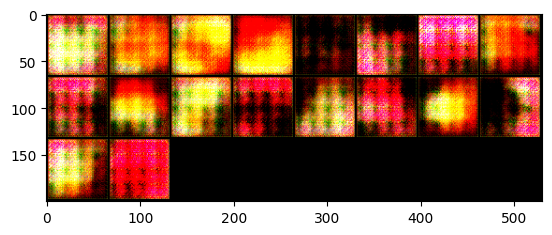

100%|██████████| 103/103 [00:22<00:00,  4.51it/s]


epoch: 1, lossD:1.6212921457961924, lossG:7.825216446108031,lossG_fake:4.534164674073747, lossG_real:3.291051812831638 ,equality:1.2431128612421087


evaluate:93.5797119140625,kid_mean:0.04498285427689552, kid_std:0.023898005485534668,kid_:(tensor(0.0450), tensor(0.0239))


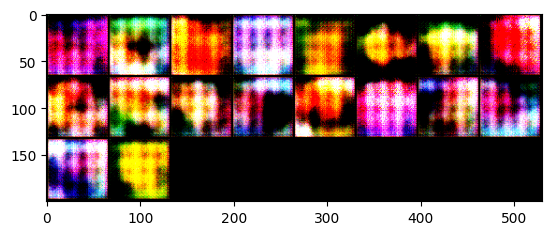

100%|██████████| 103/103 [00:20<00:00,  4.96it/s]


epoch: 2, lossD:1.6325757040560824, lossG:7.210448593769259,lossG_fake:4.307531456924179, lossG_real:2.902917145091353 ,equality:1.4046143118328263


evaluate:94.35588836669922,kid_mean:0.052406519651412964, kid_std:0.027013123035430908,kid_:(tensor(0.0524), tensor(0.0270))


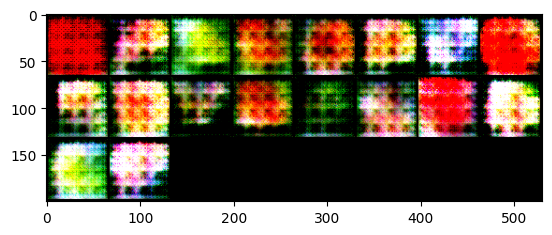

100%|██████████| 103/103 [00:20<00:00,  4.95it/s]


epoch: 3, lossD:1.7078395184961337, lossG:5.826716233225702,lossG_fake:3.395464295901141, lossG_real:2.4312519358778464 ,equality:0.9642123600232946


evaluate:87.05738830566406,kid_mean:0.04673140496015549, kid_std:0.023008348420262337,kid_:(tensor(0.0467), tensor(0.0230))


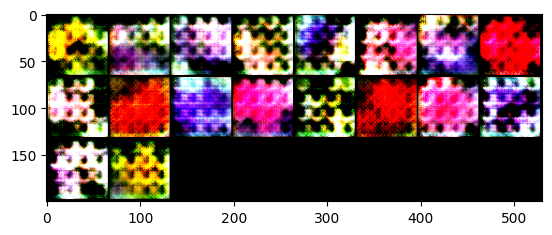

100%|██████████| 103/103 [00:21<00:00,  4.81it/s]


epoch: 4, lossD:1.719365642776767, lossG:5.791329694025725,lossG_fake:3.4274769315441835, lossG_real:2.3638527561159965 ,equality:1.063624175428187


evaluate:99.6911849975586,kid_mean:0.061666879802942276, kid_std:0.03225146606564522,kid_:(tensor(0.0617), tensor(0.0323))


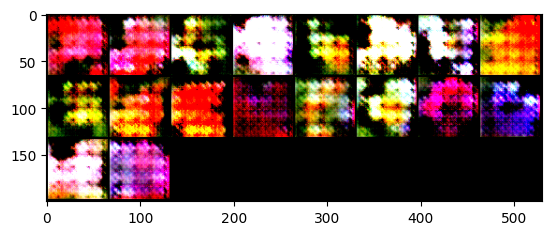

100%|██████████| 103/103 [00:20<00:00,  4.95it/s]


epoch: 5, lossD:1.5400078606258318, lossG:5.861029462906921,lossG_fake:3.4983160819822143, lossG_real:2.3627133890263083 ,equality:1.135602692955906


evaluate:100.14527130126953,kid_mean:0.06277794390916824, kid_std:0.03095925599336624,kid_:(tensor(0.0628), tensor(0.0310))


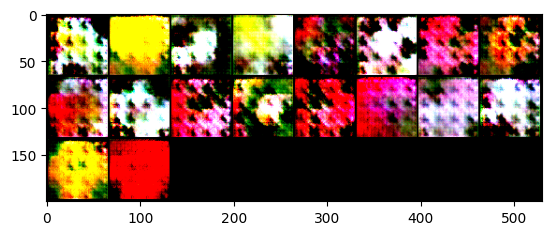

100%|██████████| 103/103 [00:21<00:00,  4.89it/s]


epoch: 6, lossD:1.3752053223767327, lossG:6.162573124598531,lossG_fake:3.5887350324288154, lossG_real:2.5738380967992023 ,equality:1.0148969356296131


evaluate:96.49855041503906,kid_mean:0.06180642545223236, kid_std:0.03330102935433388,kid_:(tensor(0.0618), tensor(0.0333))


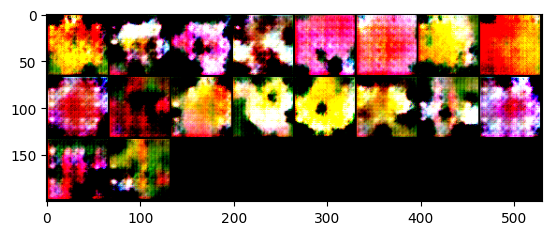

100%|██████████| 103/103 [00:21<00:00,  4.86it/s]


epoch: 7, lossD:1.3655293083306654, lossG:6.579371776395631,lossG_fake:3.9312796893629054, lossG_real:2.648092092819584 ,equality:1.2831875965433213


evaluate:95.01931762695312,kid_mean:0.05921727791428566, kid_std:0.029454845935106277,kid_:(tensor(0.0592), tensor(0.0295))


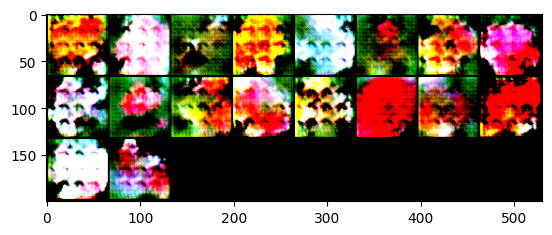

100%|██████████| 103/103 [00:20<00:00,  4.94it/s]


epoch: 8, lossD:1.3045217707319168, lossG:6.4795119785568085,lossG_fake:3.7573581771943174, lossG_real:2.722153811778837 ,equality:1.0352043654154803


evaluate:83.37004852294922,kid_mean:0.04974719136953354, kid_std:0.032280344516038895,kid_:(tensor(0.0497), tensor(0.0323))


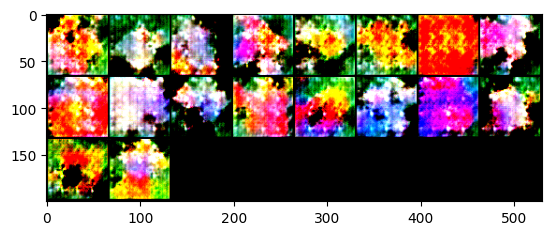

100%|██████████| 103/103 [00:21<00:00,  4.86it/s]


epoch: 9, lossD:1.381992392169619, lossG:6.203496145970613,lossG_fake:3.713650894396513, lossG_real:2.489845249259356 ,equality:1.223805645137157


evaluate:85.27607727050781,kid_mean:0.05299361050128937, kid_std:0.03140214830636978,kid_:(tensor(0.0530), tensor(0.0314))


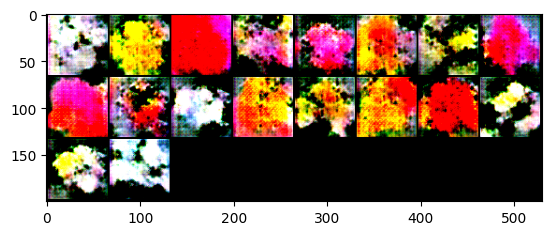

100%|██████████| 103/103 [00:20<00:00,  4.91it/s]


epoch: 10, lossD:1.4873371164775588, lossG:5.784875578093297,lossG_fake:3.3704062028995994, lossG_real:2.414469392554274 ,equality:0.9559368103453254


evaluate:88.51063537597656,kid_mean:0.06007655709981918, kid_std:0.033459894359111786,kid_:(tensor(0.0601), tensor(0.0335))


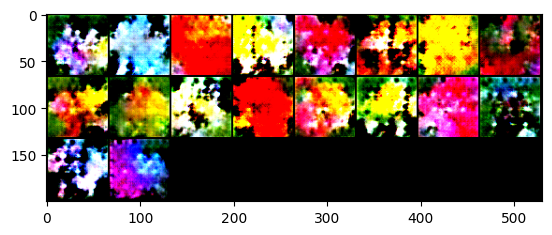

100%|██████████| 103/103 [00:21<00:00,  4.90it/s]


epoch: 11, lossD:1.303780139649956, lossG:5.970770428481611,lossG_fake:3.4945500684015958, lossG_real:2.476220362105416 ,equality:1.0183297062961798


evaluate:93.0093994140625,kid_mean:0.054353877902030945, kid_std:0.03134326636791229,kid_:(tensor(0.0544), tensor(0.0313))


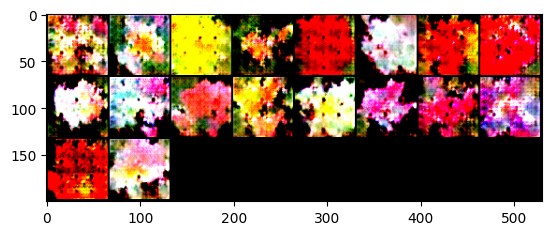

100%|██████████| 103/103 [00:21<00:00,  4.89it/s]


epoch: 12, lossD:1.3243242878358341, lossG:6.035558830187159,lossG_fake:3.4980738336600146, lossG_real:2.5374850135983773 ,equality:0.9605888200616373


evaluate:95.47561645507812,kid_mean:0.06525161862373352, kid_std:0.03614421933889389,kid_:(tensor(0.0653), tensor(0.0361))


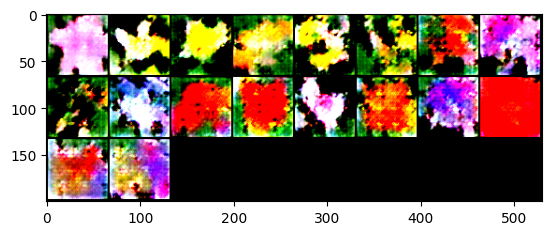

100%|██████████| 103/103 [00:21<00:00,  4.90it/s]


epoch: 13, lossD:1.2992765886112325, lossG:6.125614749575124,lossG_fake:3.5586245071540756, lossG_real:2.5669902273752156 ,equality:0.99163427977886


evaluate:94.32707214355469,kid_mean:0.07026654481887817, kid_std:0.03637783229351044,kid_:(tensor(0.0703), tensor(0.0364))


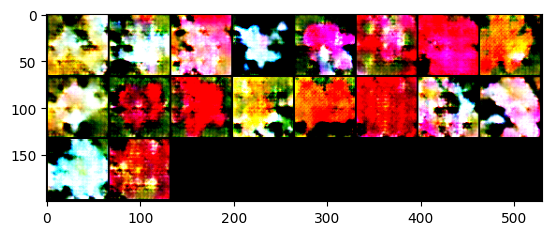

100%|██████████| 103/103 [00:21<00:00,  4.87it/s]


epoch: 14, lossD:1.2733100276548885, lossG:6.316034201279427,lossG_fake:3.6346628237696526, lossG_real:2.681371361595913 ,equality:0.9532914621737394


evaluate:93.18243408203125,kid_mean:0.07084497809410095, kid_std:0.03516578674316406,kid_:(tensor(0.0708), tensor(0.0352))


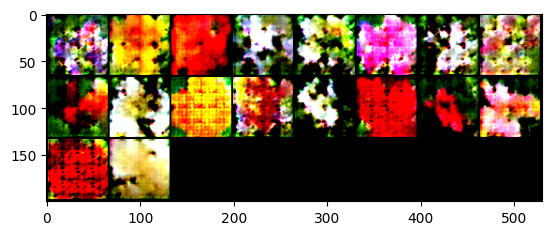

100%|██████████| 103/103 [00:20<00:00,  4.92it/s]


epoch: 15, lossD:1.1729125742194721, lossG:6.351589925080827,lossG_fake:3.625681865562513, lossG_real:2.7259080519953978 ,equality:0.8997738135671152


evaluate:92.07000732421875,kid_mean:0.06522811204195023, kid_std:0.04459764063358307,kid_:(tensor(0.0652), tensor(0.0446))


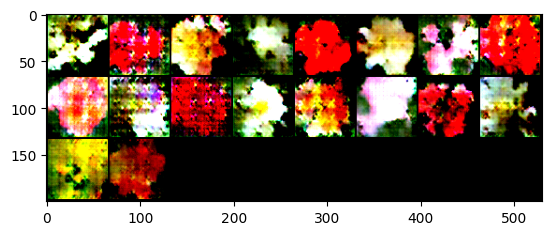

100%|██████████| 103/103 [00:21<00:00,  4.87it/s]


epoch: 16, lossD:1.2536478520018384, lossG:6.472843253496781,lossG_fake:3.7041061977738314, lossG_real:2.7687370644032376 ,equality:0.9353691333705938


evaluate:88.26874542236328,kid_mean:0.06470461934804916, kid_std:0.03607155755162239,kid_:(tensor(0.0647), tensor(0.0361))


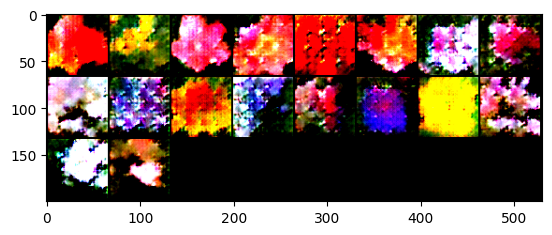

100%|██████████| 103/103 [00:20<00:00,  4.91it/s]


epoch: 17, lossD:1.1427469890094497, lossG:6.484858350846374,lossG_fake:3.650085435908975, lossG_real:2.83477291406937 ,equality:0.8153125218396049


evaluate:91.57015228271484,kid_mean:0.06703964620828629, kid_std:0.03796885162591934,kid_:(tensor(0.0670), tensor(0.0380))


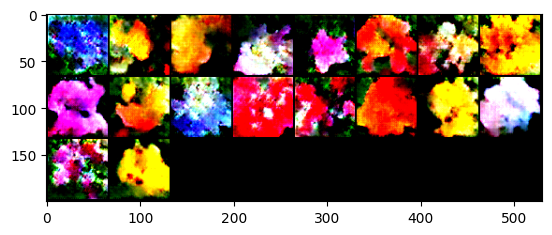

100%|██████████| 103/103 [00:21<00:00,  4.88it/s]


epoch: 18, lossD:1.0642379979485448, lossG:6.707586839361098,lossG_fake:3.8258240159275463, lossG_real:2.8817628066516616 ,equality:0.9440612092758847


evaluate:87.99259185791016,kid_mean:0.06336362659931183, kid_std:0.03762400895357132,kid_:(tensor(0.0634), tensor(0.0376))


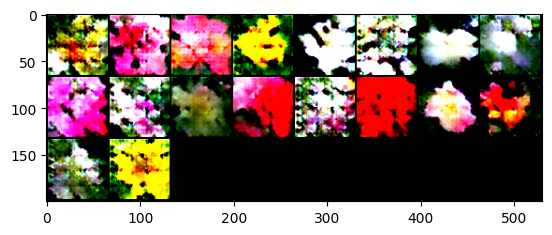

100%|██████████| 103/103 [00:20<00:00,  4.92it/s]


epoch: 19, lossD:1.2200771000200106, lossG:6.482391908330825,lossG_fake:3.627282885671819, lossG_real:2.8551090481211836 ,equality:0.7721738375506355


evaluate:88.16862487792969,kid_mean:0.06352140754461288, kid_std:0.03812669217586517,kid_:(tensor(0.0635), tensor(0.0381))


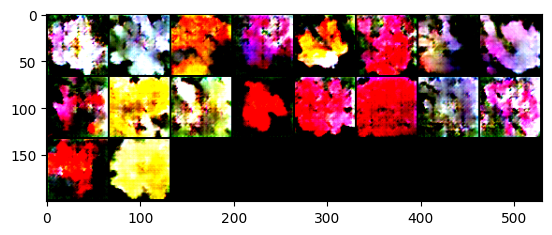

100%|██████████| 103/103 [00:21<00:00,  4.90it/s]


epoch: 20, lossD:1.1215515871649806, lossG:6.376282293819687,lossG_fake:3.5896533912825355, lossG_real:2.7866288840192035 ,equality:0.803024507263332


evaluate:85.1166763305664,kid_mean:0.06481204181909561, kid_std:0.0339251272380352,kid_:(tensor(0.0648), tensor(0.0339))


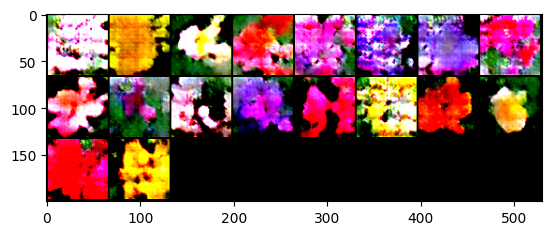

100%|██████████| 103/103 [00:20<00:00,  4.91it/s]


epoch: 21, lossD:1.1098614271404674, lossG:6.4897211037793205,lossG_fake:3.6197956441675574, lossG_real:2.8699254587437344 ,equality:0.749870185423823


evaluate:82.12235260009766,kid_mean:0.0610845647752285, kid_std:0.03561178594827652,kid_:(tensor(0.0611), tensor(0.0356))


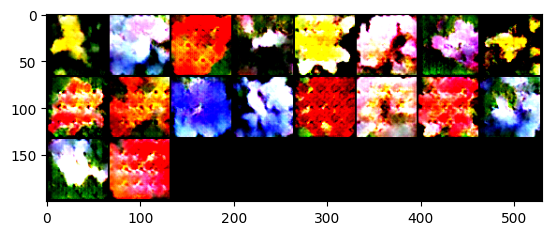

100%|██████████| 103/103 [00:21<00:00,  4.89it/s]


epoch: 22, lossD:1.1174047210262816, lossG:6.794030203402621,lossG_fake:3.860604006109886, lossG_real:2.93342618687639 ,equality:0.9271778192334961


evaluate:84.40214538574219,kid_mean:0.05772910267114639, kid_std:0.03487581014633179,kid_:(tensor(0.0577), tensor(0.0349))


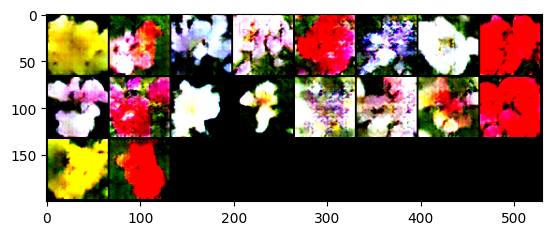

100%|██████████| 103/103 [00:21<00:00,  4.89it/s]


epoch: 23, lossD:1.0967141719697748, lossG:6.581999190802713,lossG_fake:3.654024781822001, lossG_real:2.927974391330793 ,equality:0.7260503904912081


evaluate:85.9814224243164,kid_mean:0.06725232303142548, kid_std:0.0410616397857666,kid_:(tensor(0.0673), tensor(0.0411))


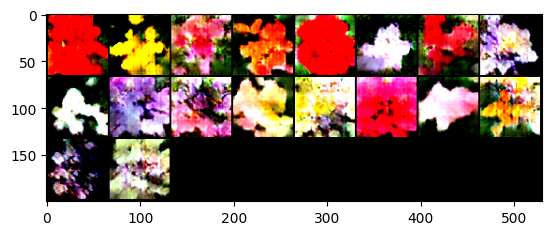

100%|██████████| 103/103 [00:21<00:00,  4.90it/s]


epoch: 24, lossD:1.0804539528286572, lossG:6.830770011087066,lossG_fake:3.872338350536754, lossG_real:2.9584316443471077 ,equality:0.9139067061896462


evaluate:87.0173110961914,kid_mean:0.06847186386585236, kid_std:0.04347619786858559,kid_:(tensor(0.0685), tensor(0.0435))


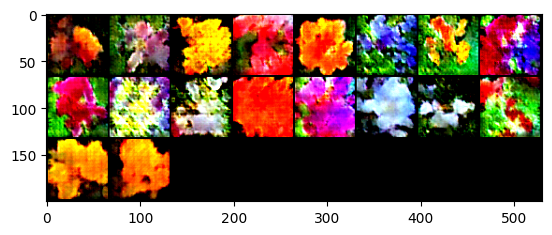

100%|██████████| 103/103 [00:21<00:00,  4.90it/s]


epoch: 25, lossD:1.1336280532832284, lossG:6.688814686340036,lossG_fake:3.7668170628038427, lossG_real:2.9219976484196857 ,equality:0.844819414384157


evaluate:87.31182861328125,kid_mean:0.06383199989795685, kid_std:0.04111572727560997,kid_:(tensor(0.0638), tensor(0.0411))


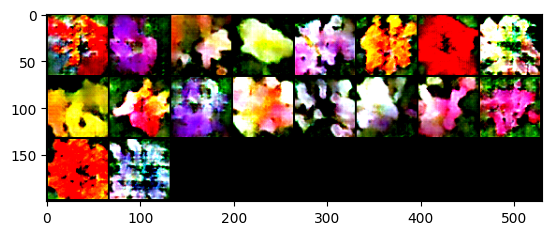

100%|██████████| 103/103 [00:21<00:00,  4.90it/s]


epoch: 26, lossD:0.9719067493688713, lossG:6.770347447071261,lossG_fake:3.8217860483428807, lossG_real:2.948561421875815 ,equality:0.8732246264670658


evaluate:89.72461700439453,kid_mean:0.0643819123506546, kid_std:0.03717433288693428,kid_:(tensor(0.0644), tensor(0.0372))


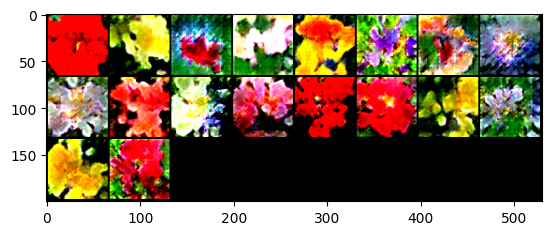

100%|██████████| 103/103 [00:20<00:00,  4.91it/s]


epoch: 27, lossD:1.132520822934734, lossG:6.615373342939951,lossG_fake:3.714193308237687, lossG_real:2.901180039910437 ,equality:0.81301326832725


evaluate:88.56733703613281,kid_mean:0.062252044677734375, kid_std:0.03773246705532074,kid_:(tensor(0.0623), tensor(0.0377))


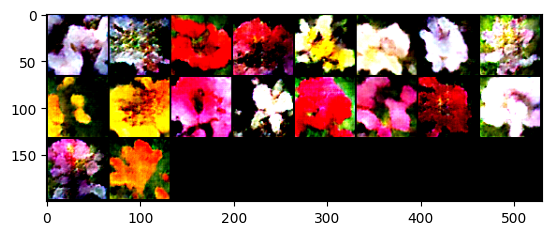

100%|██████████| 103/103 [00:21<00:00,  4.90it/s]


epoch: 28, lossD:0.9775841308450236, lossG:6.777666490054825,lossG_fake:3.816631474541229, lossG_real:2.9610350213004546 ,equality:0.8555964532407745


evaluate:88.62649536132812,kid_mean:0.0632084384560585, kid_std:0.036475472152233124,kid_:(tensor(0.0632), tensor(0.0365))


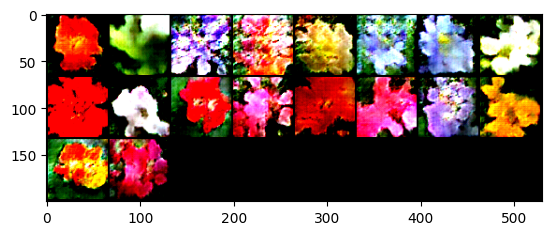

100%|██████████| 103/103 [00:21<00:00,  4.89it/s]


epoch: 29, lossD:0.9813675206263088, lossG:7.057303299024267,lossG_fake:3.97061456985844, lossG_real:3.086688752313262 ,equality:0.8839258175451778


evaluate:89.80655670166016,kid_mean:0.06313285231590271, kid_std:0.0308991651982069,kid_:(tensor(0.0631), tensor(0.0309))


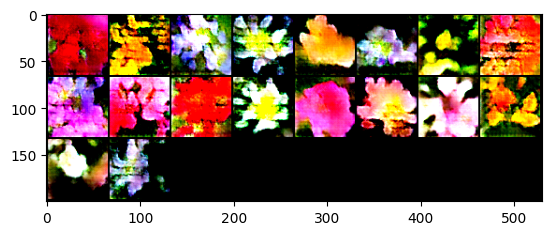

100%|██████████| 103/103 [00:20<00:00,  4.94it/s]


epoch: 30, lossD:1.1093152428714974, lossG:6.847854146679628,lossG_fake:3.839347446427762, lossG_real:3.0085067193485 ,equality:0.8308407270792619


evaluate:88.83434295654297,kid_mean:0.07099968940019608, kid_std:0.042371008545160294,kid_:(tensor(0.0710), tensor(0.0424))


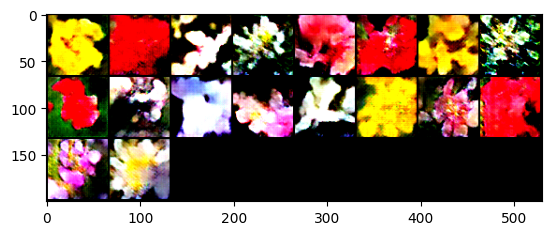

100%|██████████| 103/103 [00:21<00:00,  4.85it/s]


epoch: 31, lossD:0.9342167070768412, lossG:7.110808455828324,lossG_fake:3.952457327287174, lossG_real:3.158351150097199 ,equality:0.7941061771899753


evaluate:90.9135513305664,kid_mean:0.06493829190731049, kid_std:0.03969038650393486,kid_:(tensor(0.0649), tensor(0.0397))


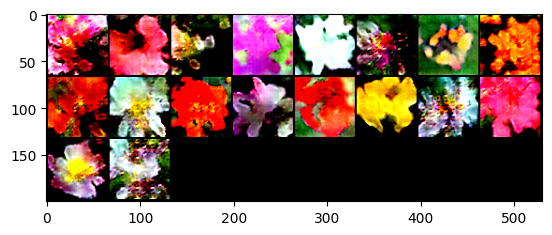

100%|██████████| 103/103 [00:20<00:00,  4.91it/s]


epoch: 32, lossD:0.9488480099775258, lossG:7.0354509353637695,lossG_fake:3.9463694500691684, lossG_real:3.0890814714061405 ,equality:0.8572879786630279


evaluate:90.63998413085938,kid_mean:0.057508669793605804, kid_std:0.03548858314752579,kid_:(tensor(0.0575), tensor(0.0355))


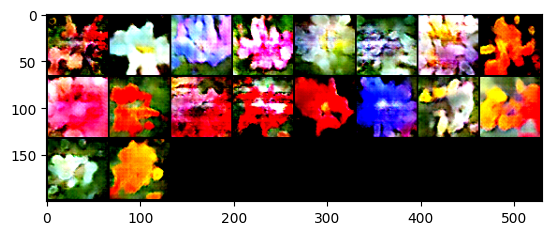

100%|██████████| 103/103 [00:20<00:00,  4.93it/s]


epoch: 33, lossD:1.0537300143137718, lossG:6.97995859905354,lossG_fake:3.892981126470473, lossG_real:3.0869774748978105 ,equality:0.8060036515726625


evaluate:90.21591186523438,kid_mean:0.055871449410915375, kid_std:0.03287054970860481,kid_:(tensor(0.0559), tensor(0.0329))


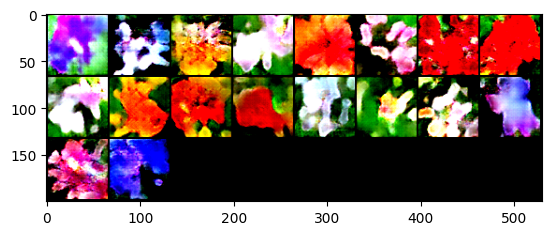

100%|██████████| 103/103 [00:21<00:00,  4.89it/s]


epoch: 34, lossD:0.9614647013469807, lossG:6.945945003657665,lossG_fake:3.8412894242018174, lossG_real:3.1046555817705914 ,equality:0.736633842431226


evaluate:90.93928527832031,kid_mean:0.05852232500910759, kid_std:0.034983742982149124,kid_:(tensor(0.0585), tensor(0.0350))


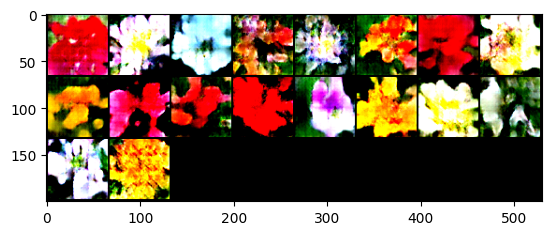

100%|██████████| 103/103 [00:21<00:00,  4.87it/s]


epoch: 35, lossD:0.8928013733289775, lossG:7.021700845181363,lossG_fake:3.831698009690035, lossG_real:3.1900028314405273 ,equality:0.6416951782495075


evaluate:89.90808868408203,kid_mean:0.05893329530954361, kid_std:0.03501328080892563,kid_:(tensor(0.0589), tensor(0.0350))


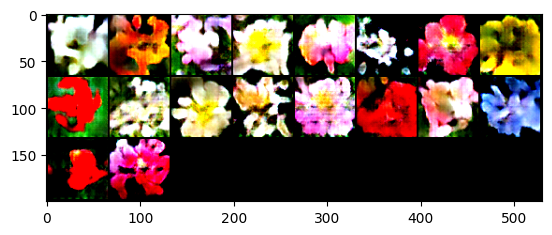

100%|██████████| 103/103 [00:20<00:00,  4.91it/s]


epoch: 36, lossD:0.89405956372474, lossG:7.211069505191544,lossG_fake:3.957374982463503, lossG_real:3.253694547032847 ,equality:0.7036804354306563


evaluate:89.67893981933594,kid_mean:0.06733421236276627, kid_std:0.04171147570014,kid_:(tensor(0.0673), tensor(0.0417))


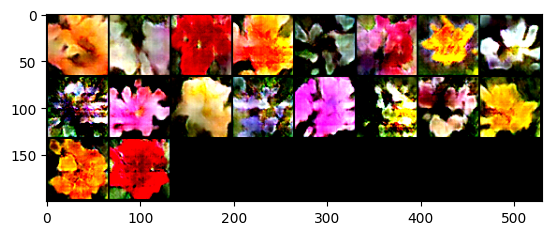

100%|██████████| 103/103 [00:21<00:00,  4.87it/s]


epoch: 37, lossD:0.9553568829031824, lossG:7.239747024276881,lossG_fake:3.9649758142175027, lossG_real:3.2747711932774886 ,equality:0.6902046209400141


evaluate:89.69218444824219,kid_mean:0.0629439651966095, kid_std:0.037908557802438736,kid_:(tensor(0.0629), tensor(0.0379))


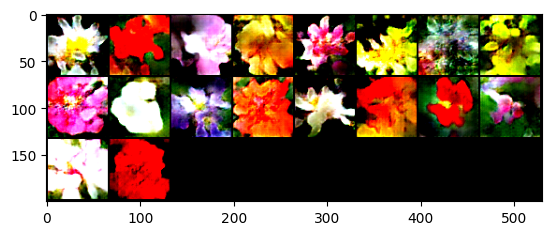

100%|██████████| 103/103 [00:21<00:00,  4.89it/s]


epoch: 38, lossD:0.8260116088158876, lossG:7.4447790719930405,lossG_fake:4.055318626385291, lossG_real:3.3894604409782634 ,equality:0.6658581854070276


evaluate:89.85467529296875,kid_mean:0.06389907002449036, kid_std:0.03810390084981918,kid_:(tensor(0.0639), tensor(0.0381))


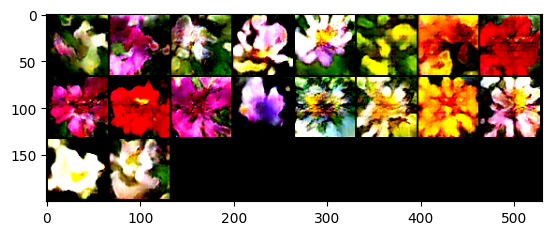

100%|██████████| 103/103 [00:20<00:00,  4.92it/s]


epoch: 39, lossD:0.8407560906653265, lossG:7.695723140123978,lossG_fake:4.2685258041307765, lossG_real:3.4271973481456053 ,equality:0.8413284559851713


evaluate:90.83274841308594,kid_mean:0.058563850820064545, kid_std:0.03248516470193863,kid_:(tensor(0.0586), tensor(0.0325))


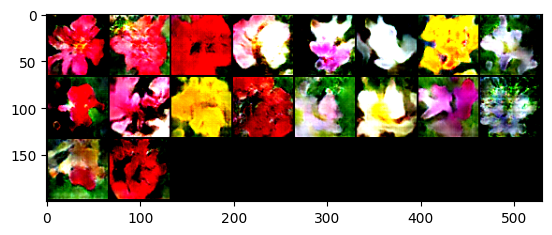

100%|██████████| 103/103 [00:21<00:00,  4.88it/s]


epoch: 40, lossD:0.9529900261499349, lossG:7.455170696221509,lossG_fake:4.13539280706239, lossG_real:3.3197779065196955 ,equality:0.8156149005426943


evaluate:92.01492309570312,kid_mean:0.0587480254471302, kid_std:0.028692951425909996,kid_:(tensor(0.0587), tensor(0.0287))


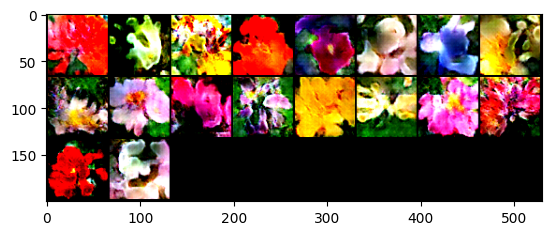

100%|██████████| 103/103 [00:20<00:00,  4.93it/s]


epoch: 41, lossD:0.8002090189352776, lossG:7.560456863884787,lossG_fake:4.119837658497894, lossG_real:3.440619206544265 ,equality:0.6792184519536288


evaluate:91.9676284790039,kid_mean:0.0644417554140091, kid_std:0.03291477635502815,kid_:(tensor(0.0644), tensor(0.0329))


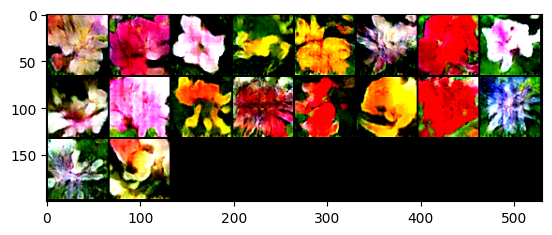

100%|██████████| 103/103 [00:21<00:00,  4.84it/s]


epoch: 42, lossD:0.8581522872436393, lossG:7.5999471192221035,lossG_fake:4.176895089519834, lossG_real:3.4230520308596417 ,equality:0.7538430586601925


evaluate:93.78471374511719,kid_mean:0.0619022473692894, kid_std:0.03711070120334625,kid_:(tensor(0.0619), tensor(0.0371))


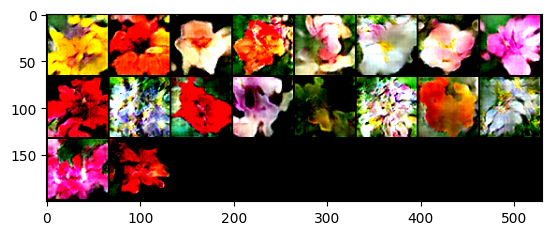

100%|██████████| 103/103 [00:20<00:00,  4.91it/s]


epoch: 43, lossD:0.9136956556908136, lossG:7.463527915547195,lossG_fake:4.112746341425238, lossG_real:3.350781568624441 ,equality:0.761964772800797


evaluate:94.689697265625,kid_mean:0.07028131186962128, kid_std:0.03686971962451935,kid_:(tensor(0.0703), tensor(0.0369))


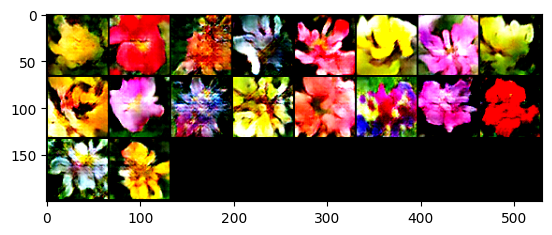

100%|██████████| 103/103 [00:20<00:00,  4.91it/s]


epoch: 44, lossD:0.7722834570025935, lossG:7.813025719911149,lossG_fake:4.24469130941965, lossG_real:3.568334391973551 ,equality:0.6763569174460993


evaluate:96.65007019042969,kid_mean:0.06347288936376572, kid_std:0.03707902505993843,kid_:(tensor(0.0635), tensor(0.0371))


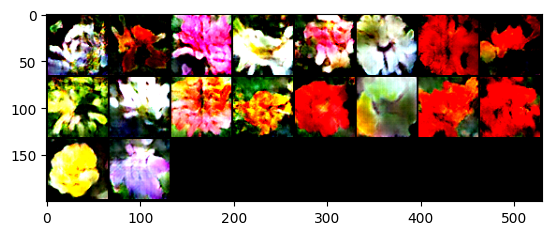

100%|██████████| 103/103 [00:21<00:00,  4.89it/s]


epoch: 45, lossD:0.7785014283020519, lossG:7.625092636034327,lossG_fake:4.225017555709024, lossG_real:3.400075082640046 ,equality:0.8249424730689778


evaluate:96.64035034179688,kid_mean:0.06749093532562256, kid_std:0.04448987916111946,kid_:(tensor(0.0675), tensor(0.0445))


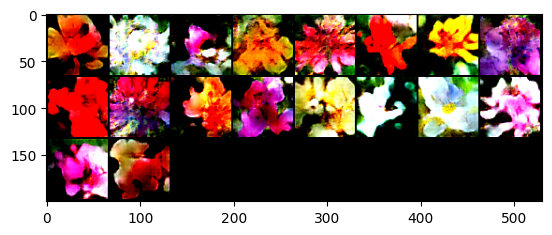

100%|██████████| 103/103 [00:21<00:00,  4.88it/s]


epoch: 46, lossD:0.8685498150806983, lossG:7.624201061656174,lossG_fake:4.115455202107291, lossG_real:3.5087458635996844 ,equality:0.6067093385076063


evaluate:97.65336608886719,kid_mean:0.06948046386241913, kid_std:0.04385726526379585,kid_:(tensor(0.0695), tensor(0.0439))


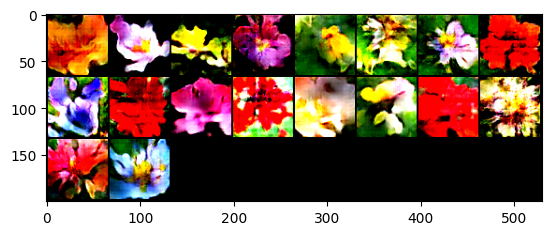

100%|██████████| 103/103 [00:21<00:00,  4.90it/s]


epoch: 47, lossD:0.7377432160875173, lossG:7.757892423463099,lossG_fake:4.263380504348903, lossG_real:3.4945119358960866 ,equality:0.7688685684528163


evaluate:97.95622253417969,kid_mean:0.07286494225263596, kid_std:0.03656408563256264,kid_:(tensor(0.0729), tensor(0.0366))


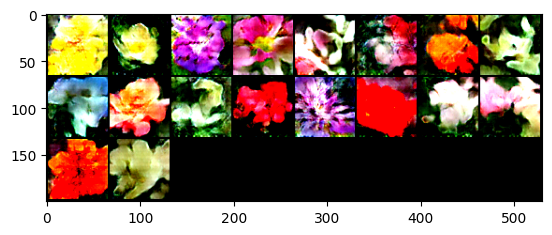

100%|██████████| 103/103 [00:21<00:00,  4.87it/s]


epoch: 48, lossD:0.8213410355801721, lossG:7.734990726396876,lossG_fake:4.157735630146508, lossG_real:3.577255097986425 ,equality:0.5804805321600832


evaluate:97.81403350830078,kid_mean:0.0658116564154625, kid_std:0.03541667014360428,kid_:(tensor(0.0658), tensor(0.0354))


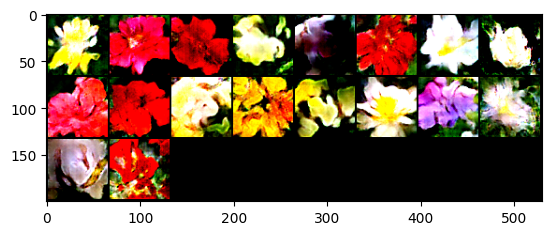

100%|██████████| 103/103 [00:21<00:00,  4.89it/s]


epoch: 49, lossD:0.7336996955778993, lossG:7.999388310515765,lossG_fake:4.360752360334674, lossG_real:3.638635935135258 ,equality:0.7221164251994159


evaluate:97.77587127685547,kid_mean:0.06529521942138672, kid_std:0.040610719472169876,kid_:(tensor(0.0653), tensor(0.0406))


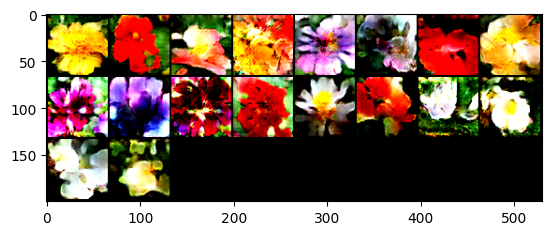

In [44]:
lossesD = []
lossesG = []

raw_lossesD = []
raw_lossesG = []
lossesG_fake = []
lossesG_real = []

equality = 0.0
sum_equality = 0.0
d_equality = []

relu = torch.nn.ReLU()

fid_ = []
kid_mean_ = []
kid_std_ = []
kid_score = []
for epoch in range(opt.n_epoch):
    running_lossD = 0.0 #損失関数初期化
    running_lossG = 0.0
    lossG_fake_running = 0.0
    lossG_real_running = 0.0

    #sum_equality += equality
    equality = 0.0
   # for i , (real_imgs, _) in enumerate(tqdm.tqdm(dataloader, position = 0)):#celebA
    for i , real_imgs in enumerate(tqdm.tqdm(dataloader, position = 0)):#flower
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size()[0]
        noise = torch.randn(batch_size, opt.z_dim, 1, 1).to(device)

        #train discriminator

        netD.zero_grad()
        output_real = netD(real_imgs)

        #lossD_real = criterion(output, labels_real)
        lossD_real = torch.mean(relu(1.0 - output_real))


        fake_imgs = netG(noise)##not train  output_fake_d
        output_fake_d = netD(fake_imgs.detach())#not train  output_fake_d

        #lossD_fake = criterion(output, labels_fake)
        lossD_fake = torch.mean(relu(1.0 + output_fake_d))


        lossD = lossD_real + lossD_fake
        #lossD = torch.mean(torch.log(torch.sigmoid(output_real)))- torch.mean(torch.log(torch.sigmoid(output_fake_d)))  #not train  output_fake_d
        lossD.backward()
        optimizerD.step()

        #train generator

        netG.zero_grad()#勾配初期

        output_fake_g = netD(fake_imgs)#train  output_fake_g
        output_real = netD(real_imgs)

        lossG_fake = torch.mean(relu(1.0 - output_fake_g))
        lossG_real = torch.mean(relu(1.0 + output_real))
        #lossG =  torch.mean(torch.log(torch.sigmoid(output_fake_g - output_real))) #- torch.mean(torch.log(torch.sigmoid(output_real)))#train  output_fake_g
        lossG =    lossG_real + lossG_fake


        lossG.backward()
        optimizerG.step()

        # save loss

        running_lossD += lossD.item()
        running_lossG += lossG.item()

        raw_lossesD.append(lossD.item())
        raw_lossesG.append(lossG.item())

        lossG_fake_running += lossG_fake.item()
        lossG_real_running += lossG_real.item()



    running_lossD /=len(dataloader)
    running_lossG /=len(dataloader)

    lossG_fake_running /= len(dataloader)
    lossG_real_running /= len(dataloader)
#equality
    equality = ( lossG_fake_running - lossG_real_running  )
    d_equality.append(equality)


    print("epoch: {}, lossD:{}, lossG:{},lossG_fake:{}, lossG_real:{} ,equality:{}".format(epoch, running_lossD, running_lossG,lossG_fake_running,lossG_real_running,equality))#-->,lossG_fake:{}, lossG_real:{},lossG_fake_running,lossG_real_running
    lossesD.append(running_lossD)
    lossesG.append(running_lossG)

    lossesG_fake.append(lossG_fake_running)
    lossesG_real.append(lossG_real_running)

     #evaluate GAN
    fake_imgs_1 = fake_imgs.detach()
    real_imgs_1 = real_imgs.to(dtype=torch.uint8).cpu()
    fake_imgs_1 = fake_imgs_1.to(dtype=torch.uint8).cpu()
    fid.update(real_imgs_1, real=True)
    fid.update(fake_imgs_1, real=False)
    eval = fid.compute()

    kid.update(real_imgs_1, real=True)
    kid.update(fake_imgs_1, real=False)
    kid_ = kid.compute()
    kid_mean, kid_std = kid.compute()



    print("evaluate:{},kid_mean:{}, kid_std:{},kid_:{}".format(eval, kid_mean, kid_std, kid_))
    fid_.append(eval)
    kid_mean_.append(kid_mean)
    kid_std_.append(kid_std)
    kid_score.append(kid_)
    #show fake image
    grid_imgs = vutils.make_grid(fake_imgs[:24].detach()+0.5)
    grid_imgs_arr = grid_imgs.cpu().numpy()
    plt.imshow(np.transpose(grid_imgs_arr, (1,2,0)))
    plt.show()

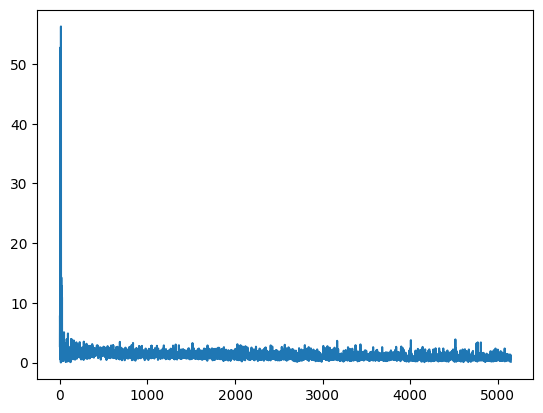

In [45]:
plt.plot(raw_lossesD)

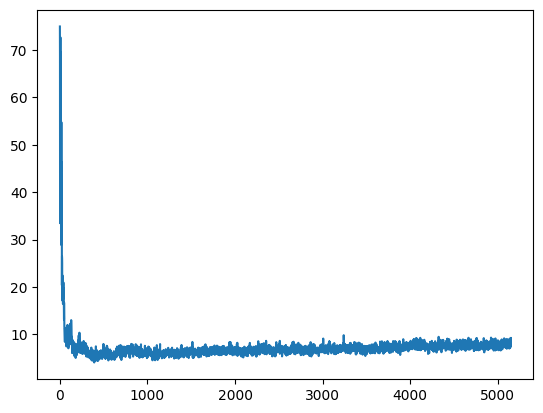

In [46]:
plt.plot(raw_lossesG)

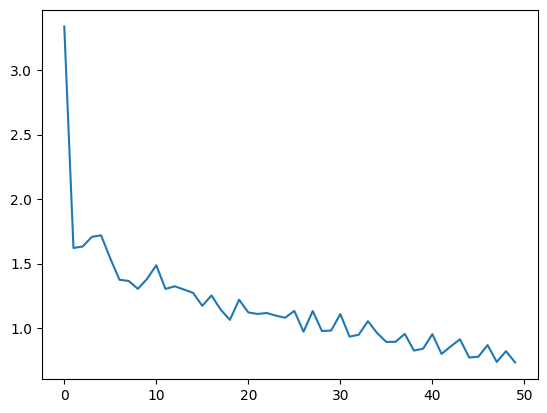

In [47]:
plt.plot(lossesD)

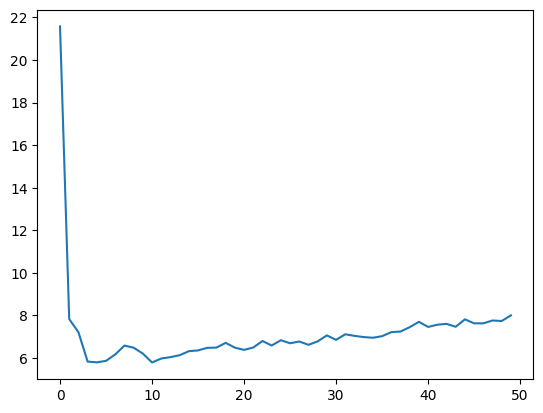

In [48]:
plt.plot(lossesG)

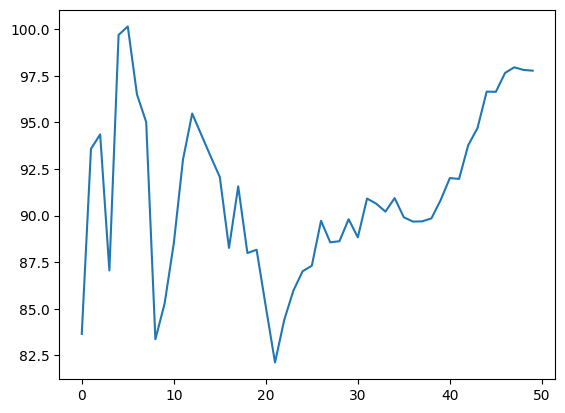

In [49]:
plt.plot(fid_)

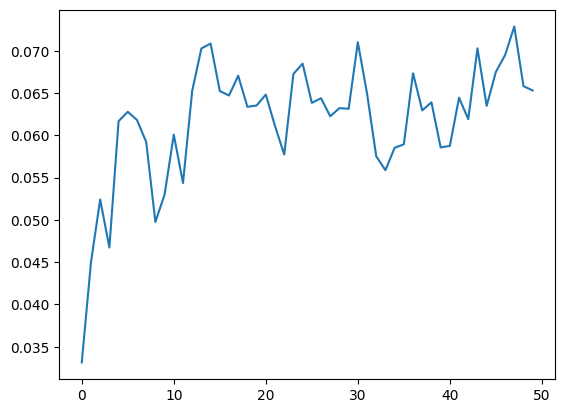

In [50]:
plt.plot(kid_mean_)

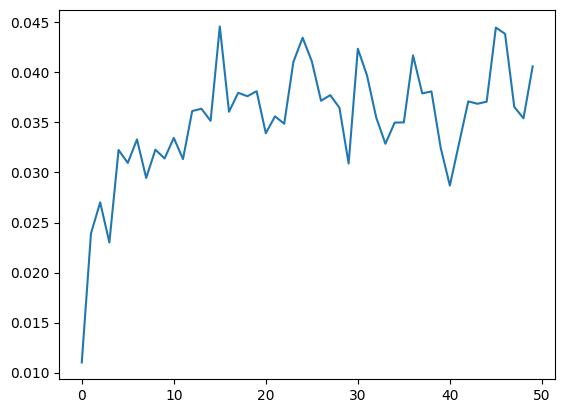

In [51]:
plt.plot(kid_std_)

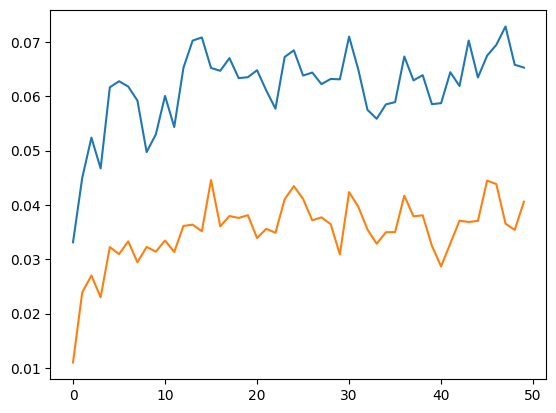

In [52]:
plt.plot(kid_score)

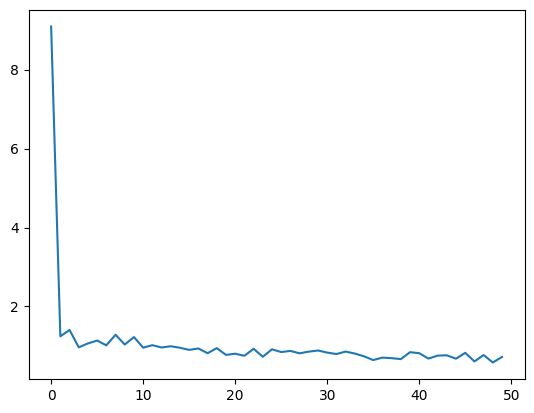

In [53]:
plt.plot(d_equality)

In [56]:

import torch
!pip install torcheval


from torcheval.metrics import PeakSignalNoiseRatio
import torch
import torchvision
#from torcheval.metrics import StructuralSimilarity

real_imgs = real_imgs.to(dtype=torch.uint8).cpu()
fake_imgs = fake_imgs.to(dtype=torch.uint8).cpu()
fid.update(real_imgs, real=True)
fid.update(fake_imgs, real=False)
print(f'fid ',fid.compute())

kid.update(real_imgs, real=True)
kid.update(fake_imgs, real=False)
print(f'kid ',kid.compute())

metric = PeakSignalNoiseRatio()
#input = torch.tensor([[0.1, 0.2], [0.3, 0.4]])
#>>> target = input * 0.9
metric.update(fake_imgs,real_imgs)
print(f'PSNR',metric.compute())#高いほどいい
#PSNR (Peak Signal-to-Noise Ratio): PSNRは、生成画像と本物の画像の間のノイズの量を測定します。高いPSNRは、より低いノイズレベルを示します。

import torch
from skimage.metrics import structural_similarity as ssim
import numpy as np

# 例えば、real_imageが与えられているとします
real_image =real_imgs # 仮のランダムな画像データ
fake_image =fake_imgs
# PyTorch TensorをNumPy配列に変換
real_image_np = real_image.cpu().numpy()

# SSIMを計算するために、0から1の範囲に正規化することが推奨されます
real_image_np = np.clip((real_image_np + 1) / 2.0, 0, 1)

# PyTorch TensorをNumPy配列に変換
fake_image_np = fake_image.cpu().numpy()

# SSIMを計算するために、0から1の範囲に正規化することが推奨されます
fake_image_np = np.clip((fake_image_np + 1) / 2.0, 0, 1)

# SSIMを計算
ssim_value = ssim(real_image_np[0], fake_image_np[0], win_size=3)
print(f"SSIM値: {ssim_value}")
#SSIMは、画像の品質を評価するための指標であり、生成画像と本物の画像の構造的な類似性を測定します。1に近い値が高い品質を示します。



fid  tensor(97.6822)
kid  (tensor(0.0646), tensor(0.0422))
PSNR tensor(74.1747)
SSIM値: 0.9590333920885767
